In [1]:
1+1

2

In [ ]:
include("cosmology.jl")
using PyPlot, ODE, Dierckx, Roots
set_bigfloat_precision(64);

In [17]:
rg(m) = 2.0.*m.*G./C./C
function miso(M0, R, r)
    3.0.*M0.*r./2.0./R.*(1.0-r.*r./3.0./R./R)
end
rgiso(M0, R, r) = rg(miso(M0, R, r))
function ρiso(M0, R, r)
    u = 3.0.*M0.*r./2.0./R
    v = 1.0-r.*r./3.0./R./R
    du = 3.0.*M0./2.0./R
    dv = -2.0.*r./3.0./R./R
    (du.*v+u.*dv)./4.0./pi./r./r
end

function thin_lens(frg, r0, rmin_sim, endy=0.0, N=100)
    const tgθ = rmin_sim/r0
    const y0 = r0*tgθ
    const θ=atan(tgθ)
    const nθ = θ-2.0*frg(y0)/y0
    const tgnθ = tan(nθ)
    const nx = (endy-y0)/tgnθ
    
    lx = linspace(0.0,1.0,div(N,2)).^3
    x = [-reverse(lx)*r0; lx*nx]
    y = zeros(length(x))
    for i in 1:length(x)
        y[i] = if x[i]<0.0
            tgθ*x[i]+y0
        else
            y[i] = y0+tgnθ*x[i]
        end
    end
    x = [(xx) for xx in x]
    y = [(yy) for yy in y]        
    x, y
end

function direct_lens(frg, r0, rmin_sim, endy=0.0, N=100)
    tx, ty = thin_lens(frg, r0, rmin_sim, endy, N)
    ϕf = π-atan(ty[end]/tx[end])
    function f(ϕ, y)
        (u, v) = y
        u_prime = v
        v_prime = 3/2*frg(1/u)*u*u-u
        [u_prime; v_prime]    
    end
    const u0 = 1.0/r0
    const tgθ = rmin_sim/r0
    const du0 = 1.0/(r0*abs(tgθ))
    start = [u0; du0];
    ϕl=linspace(0,ϕf,N)
    
    ϕ, y = ode23(f, start, ϕl, abstol=1.0e-19, reltol=1.0e-28);
    u = map(y -> y[1], y);
    x = [(v) for v in -cos(ϕ)./u]
    y = [(v) for v in sin(ϕ)./u]        
    spl = Spline1D(x,y, k=5, bc="extrapolate")
    
    t = (endy-y[end-100])/(y[end]-y[end-100])
    xmax = x[end-100]+t*(x[end]-x[end-100])
    
    #xmax = fzero(xx->evaluate(spl,xx)-endy, x[end]; order=8)    
    lx = linspace(0.0,1.0,div(N,2)).^3
    x = [-reverse(lx)*r0; lx*xmax]
    y = evaluate(spl, x)

    x,y
end

function analytic_lens(M0, R, rmin_sim, r0)
    function u_in(ϕ, M0, R, b)
        m0 = G*M0/C/C
        cos(ϕ)/b + 3*m0./2./R./b.*((3/2-b*b/R/R)*ϕ*sin(ϕ)-b*b/R/R*cos(ϕ)*log(cos(ϕ)))
    end
    
    # u = A*c1+B*c2+c3
    function u_out_cs(ϕ, M0, b)
        m0 = G*M0/C/C
        c1 = cos(ϕ)
        c2 = sin(ϕ)
        c3 = 3.*m0./2./b./b.*(1-cos(2*ϕ)/3)
        c1, c2, c3
    end
    c1_out,c2_out,c3_out = u_out_cs(π/2, M0, rmin_sim)
    # c1 == 0.0
    # 1/r0 == B*c2+c3
    Bout = (1./r0-c3_out)./c2_out

    ϕR = fzero(ϕt->(1./u_in(ϕt,M0,R,rmin_sim)-R), 0.0,pi/2)
    c1_R,c2_R,c3_R = u_out_cs(ϕR, M0, rmin_sim)
    #   since 1/R = Aout*c1 + Bout*c2 + c3 the next line reads:
    Aout = (1/R - Bout*c2_R - c3_R)/c1_R
    
    N = 1000
    x = zeros(N)
    y = zeros(N)
    ϕl = linspace(-π/2, π/2, N)
    for i in 1:N
        c1_out,c2_out,c3_out = u_out_cs(ϕl[i], M0, rmin_sim)
        u = Aout*c1_out+Bout*c2_out+c3_out
        r = 1./u
        x[i] = -r*sin(ϕl[i])
        y[i] = r*cos(ϕl[i])
    end
    x,y
end

analytic_lens (generic function with 1 method)

In [18]:
function mfac(M0, R, rp, N)
    tot = zeros(N)
    ptot = zeros(N)
    @inbounds for i in 1:N
        x=rand()*rp+1.0e-2
        y=rand()*rp+1.0e-2
        z=rand()*R+1.0e-2
        r=sqrt(x*x+y*y+z*z)
        r>R && continue
        pr = sqrt(x*x+y*y)
        pr > rp && continue
        ρ=ρiso(M0, R, r)        
        ptot[i] = ρ
        if r <= rp
            tot[i] = ρ
        end
    end
    sum(ptot)/sum(tot)
end

mfac (generic function with 1 method)

In [20]:
Mmw = 450.0;
Rmw = 200.0;
mfac(Mmw, Rmw, 10.0, 50000000)

1.5308414782805302

In [26]:
r0 = 2.7e6
rmin_sim=10.0
endy=0.0
dx,dy = direct_lens(r->rgiso(Mmw, Rmw, r), r0, rmin_sim, endy, 1000);

In [27]:
r0 = 2.7e6
rmin_sim=10.0
endy=0.0
tx,ty = thin_lens(r->rgiso(Mmw*1.53, Rmw, r), r0, rmin_sim, endy, 100000);

In [28]:
r0 = 2.7e6
rmin_sim=10.0
endy=0.0
ax,ay = analytic_lens(Mmw, Rmw, rmin_sim, r0);

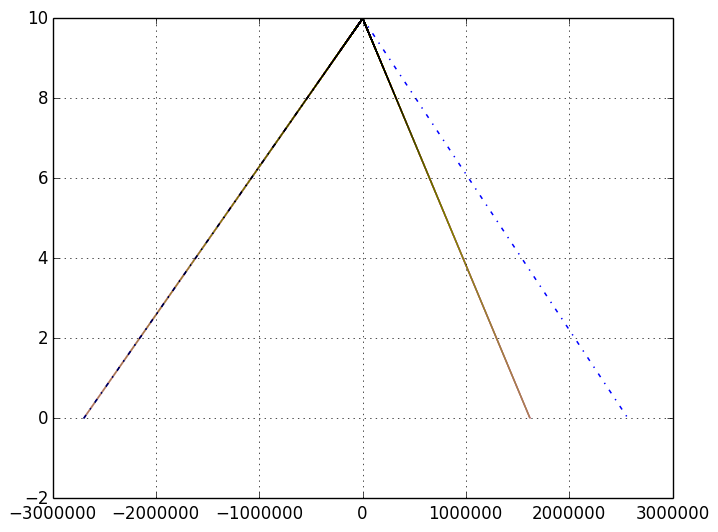

In [30]:
hold(false)
plot(dx, dy, "-.b", ms=0.02, lw=1.1)
hold(true)
plot(tx, ty, ".r", ms=0.01, lw=0.01)
plot(tx, ty, ".g", ms=0.01, lw=0.01)
hold(false)
grid(true)

analytic_lens (generic function with 1 method)

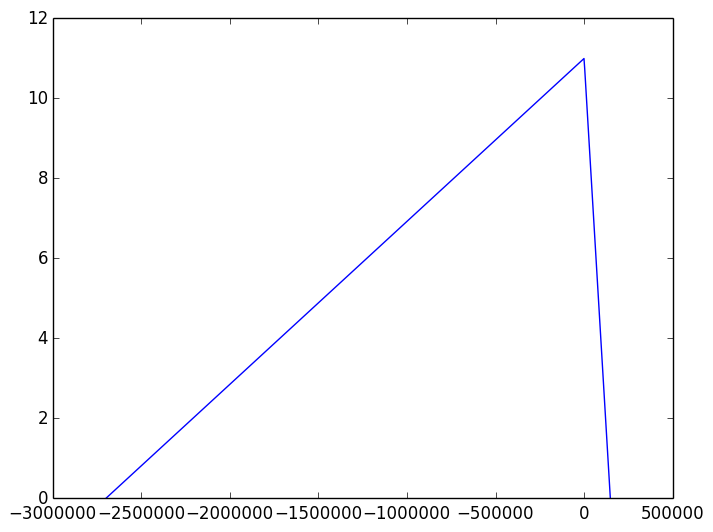

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31e07c150>

In [16]:
plot(ax,ay,"-",ms=0.02)